DEEP DREAM

>DeepDream is a computer vision program created by Google engineer Alexander Mordvintsev that uses a convolutional neural network to find and enhance patterns in images via algorithmic pareidolia, thus creating a dream-like appearance reminiscent of a psychedelic experience in the deliberately overprocessed images. [WikiPedia](https://en.wikipedia.org/wiki/DeepDream)

Google's program popularized the term (deep) "dreaming" to refer to the
generation of images that produce desired activations in a trained deep network, and the term now refers to a collection of related approaches.

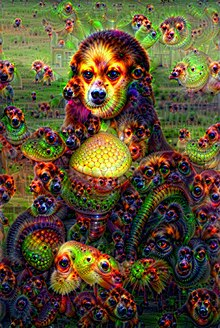









In [ ]:
import torch
from torchvision import models, transforms
from torchvision.models import resnet18
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

In [ ]:

#'my_VGG16'
#'torch_VGG16'
back_bone = 'torch_VGG16'#@param ['my_VGG16','torch_VGG16']


TEST_IMAGE_PATH = '/content/star_night.jpg'#@param
CUDA_ENABLED = 'False'#@param ['False','True']
FINAL_IMAGE_NAME = 'star_night_torch.jpg'#@param

# Deep dream configs
LAYER_ID = 28 # The layer to maximize the activations through#@param
NUM_ITERATIONS = 5 # Number of iterations#@param
LR = 0.2

NUM_DOWNSCALES = 20#@param
BLEND_ALPHA = 0.6#@param





print(back_bone)

torch_VGG16


# VGG16

In [ ]:
#@title
#@markdown
import torch
import torch.nn as nn

class VGG16(nn.Module):
  def __init__(self, in_size, num_classes=1000):
    super(VGG16, self).__init__()

    self.in_size = in_size
    self.hidden = [64, 128, 256, 512, 4096, 1000]

    self.features = nn.Sequential(
            nn.Conv2d(3, self.hidden[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[0],self.hidden[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(self.hidden[0], self.hidden[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[1],self.hidden[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(self.hidden[1], self.hidden[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[2], self.hidden[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[2], self.hidden[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(self.hidden[2], self.hidden[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[3], self.hidden[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[3], self.hidden[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(self.hidden[3], self.hidden[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[3], self.hidden[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden[3], self.hidden[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x



In [ ]:
#@title
#@markdown
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class VGG16Trainer:
    def __init__(self, device):
        self.device = device
        self.model = VGG16(3, 1000).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)

    def train(self, trainloader, epochs):
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data[0].to(self.device), data[1].to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 200:.3f}')
            running_loss = 0.0

        print('Training finished.')






In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = VGG16Trainer(device)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Start training
trainer.train(trainloader, epochs=50)
print(trainer.model.parameters())

torch.save(trainer.model.state_dict(), '/content/vgg16_pretrained.pth')

Files already downloaded and verified
Epoch: 1, Batch: 391, Loss: 12.207
Epoch: 2, Batch: 391, Loss: 4.560
Epoch: 3, Batch: 391, Loss: 4.546
Epoch: 4, Batch: 391, Loss: 4.544
Epoch: 5, Batch: 391, Loss: 4.541
Epoch: 6, Batch: 391, Loss: 4.534
Epoch: 7, Batch: 391, Loss: 4.535
Epoch: 8, Batch: 391, Loss: 4.533
Epoch: 9, Batch: 391, Loss: 4.529
Epoch: 10, Batch: 391, Loss: 4.527
Epoch: 11, Batch: 391, Loss: 4.528
Epoch: 12, Batch: 391, Loss: 4.531
Epoch: 13, Batch: 391, Loss: 4.527
Epoch: 14, Batch: 391, Loss: 4.526
Epoch: 15, Batch: 391, Loss: 4.527
Epoch: 16, Batch: 391, Loss: 4.525
Epoch: 17, Batch: 391, Loss: 4.524
Epoch: 18, Batch: 391, Loss: 4.521
Epoch: 19, Batch: 391, Loss: 4.522
Epoch: 20, Batch: 391, Loss: 4.521
Epoch: 21, Batch: 391, Loss: 4.522
Epoch: 22, Batch: 391, Loss: 4.521
Epoch: 23, Batch: 391, Loss: 4.520
Epoch: 24, Batch: 391, Loss: 4.520
Epoch: 25, Batch: 391, Loss: 4.522
Epoch: 26, Batch: 391, Loss: 4.520
Epoch: 27, Batch: 391, Loss: 4.519
Epoch: 28, Batch: 391, Lo

# Deep Dream

In [ ]:
class DeepDream:
    def __init__(self, image):
        self.image = image

        if back_bone == 'my_VGG16':
          #self.modules = list(self.model.model.classifier)
          self.model = VGG16(3, 1000)

          # Load the pretrained model's parameters
          self.model.load_state_dict(torch.load("vgg16_pretrained.pth"))

          self.modules = []
          for module in self.model.features.modules():
            self.modules.append(module)


        if back_bone == 'torch_VGG16':
          self.model = models.vgg16(pretrained=True)
          if CUDA_ENABLED:
              self.model = self.model.cuda()
          self.modules = list(self.model.features.modules())


        # vgg16 use 224x224 images
        imgSize = 224
        self.transformMean = [0.485, 0.456, 0.406]
        self.transformStd = [0.229, 0.224, 0.225]
        self.transformNormalise = transforms.Normalize(
            mean=self.transformMean,
            std=self.transformStd
        )

        self.transformPreprocess = transforms.Compose([
            transforms.Resize((imgSize, imgSize)),
            transforms.ToTensor(),
            self.transformNormalise
        ])

        self.tensorMean = torch.Tensor(self.transformMean)
        if CUDA_ENABLED:
            self.tensorMean = self.tensorMean.cuda()

        self.tensorStd = torch.Tensor(self.transformStd)
        if CUDA_ENABLED:
            self.tensorStd = self.tensorStd.cuda()

    def toImage(self, input):
        return input * self.tensorStd + self.tensorMean

In [ ]:
class DeepDream(DeepDream):
    def deepDream(self, image, layer, iterations, lr):
        transformed = self.transformPreprocess(image).unsqueeze(0)
        if CUDA_ENABLED:
            transformed = transformed.cuda()
        input = torch.autograd.Variable(transformed, requires_grad=True)
        #self.model.zero_grad()
        self.model.eval()

        for _ in range(iterations):
            out = input
            for layerId in range(layer):
                out = self.modules[layerId + 1](out)
            loss = out.norm()
            loss.backward()
            input.data = input.data + lr * input.grad.data

        input = input.data.squeeze()
        input.transpose_(0,1)
        input.transpose_(1,2)
        input = np.clip(self.toImage(input), 0, 1)
        return Image.fromarray(np.uint8(input*255))

In [ ]:
class DeepDream(DeepDream):
    def deepDreamRecursive(self, image, layer, iterations, lr, num_downscales):
        if num_downscales > 0:
            # scale down the image
            image_small = image.filter(ImageFilter.GaussianBlur(2))
            small_size = (int(image.size[0]/2), int(image.size[1]/2))
            if (small_size[0] == 0 or small_size[1] == 0):
                small_size = image.size
            image_small = image_small.resize(small_size, Image.ANTIALIAS)

            # run deepDreamRecursive on the scaled down image
            image_small = self.deepDreamRecursive(image_small, layer, iterations, lr, num_downscales-1)

            # Scale up the result image to the original size
            image_large = image_small.resize(image.size, Image.ANTIALIAS)

            # Blend the two image
            image = ImageChops.blend(image, image_large, BLEND_ALPHA)
        img_result = self.deepDream(image, layer, iterations, lr)
        img_result = img_result.resize(image.size)
        return img_result

    def deepDreamProcess(self):
        return self.deepDreamRecursive(self.image, LAYER_ID, NUM_ITERATIONS, LR, NUM_DOWNSCALES)

# test image

Text(0.5, 1.0, 'Image loaded from /content/star_night.jpg')

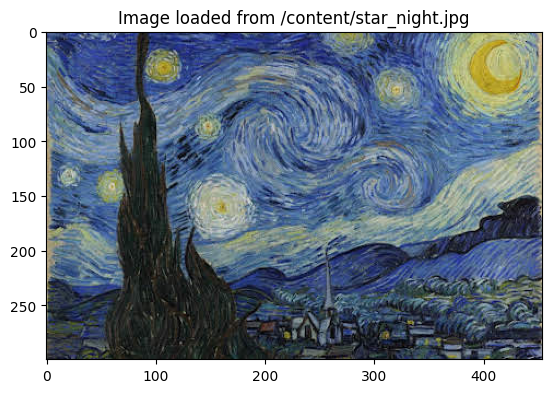

In [ ]:
img = Image.open(TEST_IMAGE_PATH)

pyplot.imshow(img)
pyplot.title("Image loaded from " + TEST_IMAGE_PATH)

In [ ]:
img_deep_dream = DeepDream(img).deepDreamProcess()
pyplot.imshow(img_deep_dream)
pyplot.title("Deep dream image")

# save

In [ ]:
!mkdir test_img

img_deep_dream.save('/content/test_img/{}'.format(FINAL_IMAGE_NAME))